# COURSERA IBM CAPSTONE PROJECT


# HUMAN DEVELOPMENT INDEX IN BRAZIL: 

## ANALYSIS OF FACTORS INFLUENCING RESULTS



### (material for Blogpost publication in specialized media)


In [1]:
import numpy as np
import pandas as pd # library for data analsysis

import matplotlib.pyplot as plt
import seaborn as sns

from geopy.geocoders import Nominatim

import json # library to handle JSON files

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

import folium

### IMPORT HUMAN DEVELOPMENT INDEX DATA FROM UNITED NATIONS 

In [2]:
webdata=pd.read_html('http://www.br.undp.org/content/brazil/pt/home/idh0/rankings/idhm-municipios-2010.html', header=0) #read all URL tables
hdi=pd.DataFrame(webdata[0]) #select 1st table and convert to dataframe

In [3]:
hdi.rename(columns={'IDHM 2010':'HDI', 'Município':'City'}, inplace=True)
hdi.drop(['Ranking IDHM 2010','IDHM Renda 2010','IDHM Longevidade 2010','IDHM Educação 2010'], axis=1, inplace=True)
hdi['State']=hdi['City'].apply(lambda x:x[-3:-1])
hdi['City']=hdi['City'].apply(lambda x:x[:-5])
hdi['HDI Block']=hdi['HDI'].apply(lambda x:x//20) #group HDI cities in 20 blocks, 50 points wide. This column will be the target for classificiation
hdi['State'].replace(
    {'AC':'Acre',
     'AL':'Alagoas',
     'AP':'Amapá', 
     'AM':'Amazonas', 
     'BA':'Bahia',
     'CE':'Ceará', 
     'DF':'Distrito Federal', 
     'ES':'Espírito Santo',
     'GO':'Goiás',
     'MA':'Maranhão',
     'MT':'Mato Grosso',
     'MS':'Mato Grosso do Sul',
     'MG':'Minas Gerais',
     'PA':'Pará',
     'PB':'Paraíba',
     'PR':'Paraná',
     'PE':'Pernambuco',
     'PI':'Piauí',
     'RJ':'Rio de Janeiro',
     'RN':'Rio Grande do Norte',
     'RS':'Rio Grande do Sul',
     'RO':'Rondônia',
     'RR':'Roraima',
     'SC':'Santa Catarina',
     'SP':'São Paulo',
     'SE':'Sergipe',
     'TO':'Tocantins'
    }, inplace=True)
hdi.head()

,City,HDI,State,HDI Block
0,São Caetano do Sul,862,São Paulo,43
1,Águas de São Pedro,854,São Paulo,42
2,Florianópolis,847,Santa Catarina,42
3,Balneário Camboriú,845,Santa Catarina,42
4,Vitória,845,Espírito Santo,42


### IMPORT PER CAPITA INCOME FROM IBGE

In [4]:
webdata=pd.read_html('https://pt.wikipedia.org/wiki/Lista_de_munic%C3%ADpios_do_Brasil_por_renda_per_capita', header=0) #read all URL tables
pci=pd.DataFrame(webdata[1]) #select 1st table and convert to dataframe

In [5]:
pci.rename(columns={'Renda per capita (R$)':'PCI', 'Município':'City', 'Estado':'State'}, inplace=True)
pci.drop('Posição', axis=1, inplace=True)
pci.head()

,City,State,PCI
0,Niterói,Rio de Janeiro,230346
1,Vitória,Espírito Santo,221507
2,São Caetano do Sul,São Paulo,218941
3,Porto Alegre,Rio Grande do Sul,212519
4,Brasília,Distrito Federal,209783


### IMPORT POPULATION

In [6]:
webdata=pd.read_html('https://pt.wikipedia.org/wiki/Lista_de_munic%C3%ADpios_do_Brasil_por_popula%C3%A7%C3%A3o', header=0) #read all URL tables
pop=pd.DataFrame(webdata[0]) #select 1st table and convert to dataframe

In [7]:
pop.rename(columns={'População':'Population', 'Município':'City', 'Unidade federativa':'State'}, inplace=True)
pop.drop(['Código IBGE', 'Posição'], axis=1, inplace=True)
pop.head()

,City,State,Population
0,São Paulo,São Paulo,12106920
1,Rio de Janeiro,Rio de Janeiro,6520266
2,Brasília,Distrito Federal,3039444
3,Salvador,Bahia,2953986
4,Fortaleza,Ceará,2627482


In [8]:
sites=pd.read_csv('C:/Users/Paulo/Desktop/Python/rbs.csv')
sites.rename(columns={'NOME DO MUNICÍPIO':'City', 'Site based on Max (T or V)':'RBS','UF':'State'}, inplace=True)
sites['State'].replace(
    {'AC':'Acre',
     'AL':'Alagoas',
     'AP':'Amapá', 
     'AM':'Amazonas', 
     'BA':'Bahia',
     'CE':'Ceará', 
     'DF':'Distrito Federal', 
     'ES':'Espírito Santo',
     'GO':'Goiás',
     'MA':'Maranhão',
     'MT':'Mato Grosso',
     'MS':'Mato Grosso do Sul',
     'MG':'Minas Gerais',
     'PA':'Pará',
     'PB':'Paraíba',
     'PR':'Paraná',
     'PE':'Pernambuco',
     'PI':'Piauí',
     'RJ':'Rio de Janeiro',
     'RN':'Rio Grande do Norte',
     'RS':'Rio Grande do Sul',
     'RO':'Rondônia',
     'RR':'Roraima',
     'SC':'Santa Catarina',
     'SP':'São Paulo',
     'SE':'Sergipe',
     'TO':'Tocantins'
    }, inplace=True)
sites.head()

,City,State,RBS
0,São Paulo,São Paulo,1077
1,Rio de Janeiro,Rio de Janeiro,666
2,Brasília,Distrito Federal,328
3,Salvador,Bahia,176
4,Fortaleza,Ceará,176


### IMPORT LATITUDE AND LONGITUDE DATA 

In [9]:
ll=pd.read_csv('C:/Users/Paulo/Desktop/Python/municipios_brasileiros.csv')
ll.head()

,codigo_ibge,nome_municipio,codigo_uf,uf,estado,capital,latitude,longitude
0,5200050,Abadia de Goiás,52,GO,Goiás,0,-16.75730,-49.4412
1,3100104,Abadia dos Dourados,31,MG,Minas Gerais,0,-18.48310,-47.3916
2,5200100,Abadiânia,52,GO,Goiás,0,-16.19700,-48.7057
3,3100203,Abaeté,31,MG,Minas Gerais,0,-19.15510,-45.4444
4,1500107,Abaetetuba,15,PA,Pará,0,-1.72183,-48.8788


In [10]:
ll.rename(columns={'nome_municipio':'City','estado':'State', 'latitude':'Latitude', 'longitude':'Longitude'}, inplace=True)
ll.drop(['codigo_ibge', 'codigo_uf','uf','capital' ], axis=1, inplace=True)
ll.head()

,City,State,Latitude,Longitude
0,Abadia de Goiás,Goiás,-16.75730,-49.4412
1,Abadia dos Dourados,Minas Gerais,-18.48310,-47.3916
2,Abadiânia,Goiás,-16.19700,-48.7057
3,Abaeté,Minas Gerais,-19.15510,-45.4444
4,Abaetetuba,Pará,-1.72183,-48.8788


### CONSOLIDATE DATA IN SINGLE DATAFRAME

In [11]:
dem = hdi.merge(pci, left_on=['City','State'], right_on=['City','State'])
dem = dem.merge(pop, left_on=['City','State'], right_on=['City','State'])
dem = dem.merge(sites, left_on=['City','State'], right_on=['City','State'])
dem = dem.merge(ll, left_on=['City','State'], right_on=['City','State'])

### CREATE VENUES DATAFRAME FOR FILLING WITH DATA FROM FOURSQUARE

In [12]:
zero_data_df = np.zeros(shape=(len(dem['City']),1))
zero_venues = pd.DataFrame(zero_data_df, columns=['Venues'])
dem=pd.concat([dem,zero_venues], axis=1, join='outer')
dem.head(10)

,City,HDI,State,HDI Block,PCI,Population,RBS,Latitude,Longitude,Venues
0,São Caetano do Sul,862,São Paulo,43,218941,159608,14,-23.6229,-46.5548,0.0
1,Águas de São Pedro,854,São Paulo,42,186622,3268,1,-22.5977,-47.8734,0.0
2,Florianópolis,847,Santa Catarina,42,209656,485838,85,-27.5945,-48.5477,0.0
3,Balneário Camboriú,845,Santa Catarina,42,193390,135268,23,-26.9926,-48.6352,0.0
4,Vitória,845,Espírito Santo,42,221507,363140,59,-20.3155,-40.3128,0.0
5,Santos,840,São Paulo,42,201383,434742,59,-23.9535,-46.3350,0.0
6,Niterói,837,Rio de Janeiro,41,230346,499028,74,-22.8832,-43.1034,0.0
7,Joaçaba,827,Santa Catarina,41,151926,29608,3,-27.1721,-51.5108,0.0
8,Brasília,824,Distrito Federal,41,209783,3039444,328,-15.7795,-47.9297,0.0
9,Curitiba,823,Paraná,41,180245,1908359,206,-25.4195,-49.2646,0.0


### CALCULATE TOTAL NUMBER OF CITIES FOR FOURSQUARE ITERATION

In [13]:
y=len(dem['City'])
print(len(dem['City']))

2955


### FourSquare Credentials

In [14]:
CLIENT_ID = 'DRARNP4SUW2J1FRUWIFRNXCIBIESD2SAPM5FQNKLYS3IWSJE' # your Foursquare ID
CLIENT_SECRET = 'U4H0PDTCYDQQKJUNJV2DIFFMTBKGEG045W1YU3QGANNN5Q4I' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: DRARNP4SUW2J1FRUWIFRNXCIBIESD2SAPM5FQNKLYS3IWSJE
CLIENT_SECRET:U4H0PDTCYDQQKJUNJV2DIFFMTBKGEG045W1YU3QGANNN5Q4I


### DEFINE FUNCTIONS TO ITERATE AND EXTRACT DATA FROM FOURSQUARE

In [15]:
# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

In [16]:
def getvenues (municipio, neighborhood_latitude, neighborhood_longitude):
    # type your answer here
    LIMIT = 100 # limit of number of venues returned by Foursquare API
    radius = 3000 # define radius
    # create URL
    url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
        CLIENT_ID, 
        CLIENT_SECRET, 
        VERSION, 
        neighborhood_latitude, 
        neighborhood_longitude, 
        radius, 
        LIMIT)
    #print (url) # display URL
    
    try:
        results = requests.get(url).json()
        results
    
    
        #print(results['response']['groups'][0]['items'])
        venues = results['response']['groups'][0]['items']
    
        nearby_venues = json_normalize(venues) # flatten JSON
        #print (nearby_venues.columns)
    except:
        return 0
        
    
    if len(nearby_venues.columns)!= 0:
    
        # filter columns
        filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
        nearby_venues =nearby_venues.loc[:, filtered_columns]
        #print('*')

        # filter the category for each row
        nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)
        #print('#')

        # clean columns
        nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]

        nearby_venues.head()
    
        print('{} venues in {}.'.format(nearby_venues.shape[0],municipio))
        z=nearby_venues.shape[0]
        return z
    else:
        return 0

## COLLECT DATA FROM FOURSQUARE FOR ALL MUNICIPALITIES

In [17]:
for i in range (0,y):
    dem['Venues'].iloc[i] = getvenues(dem['City'].iloc[i], dem['Latitude'].iloc[i], dem['Longitude'].iloc[i])

100 venues in São Caetano do Sul.


C:\Users\Paulo\Anaconda3\lib\site-packages\pandas\core\indexing.py:189: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


36 venues in Águas de São Pedro.
100 venues in Florianópolis.
100 venues in Balneário Camboriú.
100 venues in Vitória.
100 venues in Santos.
100 venues in Niterói.
56 venues in Joaçaba.
100 venues in Brasília.
100 venues in Curitiba.
100 venues in Jundiaí.
81 venues in Valinhos.
100 venues in Vinhedo.
100 venues in Santo André.
100 venues in Araraquara.
43 venues in Santana de Parnaíba.
63 venues in Nova Lima.
41 venues in Ilha Solteira.
100 venues in Americana.
100 venues in Belo Horizonte.
100 venues in São José.
100 venues in Joinville.
100 venues in Maringá.
100 venues in São José dos Campos.
100 venues in Blumenau.
100 venues in Presidente Prudente.
5 venues in Rio Fortuna.
100 venues in São Paulo.
90 venues in Assis.
100 venues in Campinas.
100 venues in São Bernardo do Campo.
100 venues in Porto Alegre.
100 venues in São Carlos.
100 venues in Rio Claro.
100 venues in Jaraguá do Sul.
69 venues in Rio do Sul.
100 venues in Bauru.
46 venues in São Miguel do Oeste.
53 venues in Pira

33 venues in Paraguaçu Paulista.
51 venues in Sumaré.
5 venues in David Canabarro.
5 venues in Saldanha Marinho.
44 venues in Itupeva.
7 venues in Serranópolis do Iguaçu.
5 venues in Boa Vista do Buricá.
42 venues in Mirassol.
23 venues in Osvaldo Cruz.
44 venues in Itapira.
84 venues in Torres.
36 venues in São Joaquim da Barra.
41 venues in Mococa.
33 venues in Santa Cruz do Rio Pardo.
46 venues in São Francisco do Sul.
2 venues in Nova Pádua.
7 venues in Indiana.
82 venues in Alfenas.
17 venues in Panambi.
10 venues in Itapoá.
7 venues in Entre Rios do Oeste.
100 venues in Umuarama.
4 venues in Vila Maria.
4 venues in São João do Oeste.
7 venues in Taió.
32 venues in Batatais.
76 venues in Conselheiro Lafaiete.
12 venues in Iguaba Grande.
2 venues in Zortéa.
59 venues in Sertãozinho.
7 venues in Itaara.
100 venues in Sete Lagoas.
6 venues in Goiandira.
4 venues in Campinas do Sul.
35 venues in Araranguá.
7 venues in Santa Adélia.
16 venues in Tapejara.
12 venues in Serafina Corrêa.


5 venues in Dumont.
46 venues in Sorriso.
45 venues in Itápolis.
8 venues in Pires do Rio.
6 venues in Coronel Freitas.
2 venues in Bento de Abreu.
49 venues in Leme.
69 venues in Formosa.
14 venues in Perdões.
5 venues in Barra do Jacaré.
53 venues in Paracatu.
20 venues in Santa Helena.
8 venues in Coronel Barros.
7 venues in Salete.
5 venues in Poço das Antas.
6 venues in Bicas.
15 venues in São Manuel.
4 venues in Mendonça.
5 venues in Vista Alegre do Alto.
73 venues in Três Lagoas.
5 venues in Lobato.
8 venues in Arealva.
83 venues in Rio Grande.
2 venues in Santa Cruz da Esperança.
1 venues in Nova Luzitânia.
6 venues in Imigrante.
4 venues in Jussara.
48 venues in Dois Irmãos.
7 venues in Sobradinho.
4 venues in Augusto Pestana.
4 venues in Macaubal.
100 venues in Capão da Canoa.
67 venues in Penha.
4 venues in Descanso.
34 venues in Promissão.
14 venues in Mairinque.
30 venues in Jacarezinho.
30 venues in Caxambu.
18 venues in Morro Reuter.
5 venues in Guatapará.
12 venues in J

68 venues in Sabará.
56 venues in Guararema.
4 venues in Relvado.
50 venues in Rio Quente.
20 venues in Três Pontas.
4 venues in Caçu.
28 venues in Frutal.
2 venues in Palmelo.
76 venues in Bertioga.
5 venues in Borda da Mata.
50 venues in Itaperuna.
4 venues in Raposos.
5 venues in Itajobi.
63 venues in Guaíba.
2 venues in Mariano Moro.
5 venues in Ilópolis.
1 venues in Sagres.
4 venues in Guarujá do Sul.
4 venues in Patrocínio Paulista.
31 venues in Ivaiporã.
4 venues in Mineiros do Tietê.
5 venues in Quilombo.
4 venues in Natividade.
100 venues in Teresópolis.
6 venues in Anchieta.
27 venues in Itabirito.
14 venues in Casa Branca.
1 venues in Óleo.
2 venues in Adolfo.
5 venues in Altinópolis.
19 venues in Colorado.
7 venues in Tupãssi.
4 venues in Engenheiro Beltrão.
4 venues in Borborema.
3 venues in Ipiguá.
3 venues in Pedrinópolis.
4 venues in Treze de Maio.
12 venues in Roca Sales.
5 venues in Cidreira.
10 venues in Rio dos Cedros.
5 venues in Cordeiro.
3 venues in Rio do Campo.

5 venues in Salto do Lontra.
7 venues in Três Cachoeiras.
4 venues in Tombos.
11 venues in Nova Santa Rita.
4 venues in Tupandi.
56 venues in Santo Antônio da Platina.
32 venues in Palmeira.
1 venues in Dobrada.
4 venues in Cariacica.
32 venues in Cacoal.
6 venues in Fundão.
4 venues in Guará.
52 venues in Araruama.
1 venues in Vargem Bonita.
12 venues in Mandaguaçu.
1 venues in Paulistânia.
5 venues in Lagamar.
5 venues in Jussara.
3 venues in Jaboti.
11 venues in Ibiá.
4 venues in Nova Veneza.
4 venues in Campina Grande do Sul.
11 venues in Santo Antônio de Pádua.
2 venues in Narandiba.
3 venues in Itaguaru.
4 venues in Cidade Gaúcha.
25 venues in Mineiros.
4 venues in Cidade Ocidental.
38 venues in Viamão.
9 venues in Borrazópolis.
28 venues in Santo Antônio da Patrulha.
2 venues in Ocauçu.
5 venues in Mato Queimado.
28 venues in Ponte Nova.
6 venues in Paranapanema.
4 venues in Itobi.
4 venues in Campina do Monte Alegre.
4 venues in Eldorado do Sul.
3 venues in São José do Alegre.


1 venues in Estrela do Norte.
1 venues in Áurea.
3 venues in Itirapuã.
2 venues in Montes Claros de Goiás.
3 venues in Conselheiro Mairinck.
4 venues in Minaçu.
4 venues in Arroio do Tigre.
4 venues in Leópolis.
47 venues in Jaguarão.
1 venues in Rio Branco.
1 venues in Irati.
5 venues in Costa Rica.
28 venues in Chuí.
5 venues in Planalto.
5 venues in Itatinga.
5 venues in Doutor Maurício Cardoso.
2 venues in Cromínia.
40 venues in Santo Antônio do Pinhal.
5 venues in Xambrê.
13 venues in Laranjeiras do Sul.
19 venues in Lapa.
5 venues in Hidrolândia.
10 venues in Ivaté.
2 venues in Campestre da Serra.
7 venues in Ibiraci.
5 venues in Iporã.
1 venues in Princesa.
4 venues in Joviânia.
43 venues in Caratinga.
7 venues in Campo Florido.
21 venues in Dionísio Cerqueira.
10 venues in Caetanópolis.
5 venues in Cachoeira de Minas.
4 venues in Mossâmedes.
5 venues in Capanema.
20 venues in Barracão.
4 venues in Santa Bárbara de Goiás.
3 venues in Campos Novos Paulista.
4 venues in Três Barra

2 venues in Moiporá.
8 venues in Tuneiras do Oeste.
1 venues in Araçaí.
4 venues in Capim Branco.
1 venues in Morro Agudo de Goiás.
4 venues in Areiópolis.
2 venues in Iraí de Minas.
6 venues in Prata.
2 venues in Anahy.
37 venues in Sarandi.
6 venues in Cruzília.
4 venues in Elias Fausto.
11 venues in Carangola.
5 venues in São João do Sul.
4 venues in Cristiano Otoni.
2 venues in Tabaporã.
1 venues in Pinhal de São Bento.
12 venues in Tapes.
3 venues in José Boiteux.
5 venues in Campo Alegre de Goiás.
100 venues in Camaçari.
8 venues in Astolfo Dutra.
4 venues in Piên.
3 venues in São João da Urtiga.
1 venues in Heitoraí.
16 venues in Paraopeba.
100 venues in Juazeiro do Norte.
8 venues in Arvorezinha.
4 venues in Deodápolis.
4 venues in Clevelândia.
16 venues in Goianira.
1 venues in Abdon Batista.
6 venues in Nova Alvorada do Sul.
1 venues in Itambaracá.
24 venues in Urubici.
4 venues in Muqui.
5 venues in Coqueiral.
7 venues in Cajati.
1 venues in Cabrália Paulista.
8 venues in Ag

4 venues in Quedas do Iguaçu.
2 venues in Rio Bananal.
4 venues in Erval Grande.
8 venues in Roncador.
4 venues in Contenda.
3 venues in Serranópolis.
2 venues in Itatiba do Sul.
5 venues in Três Barras do Paraná.
2 venues in Nova Glória.
4 venues in Inocência.
5 venues in Boa Esperança do Sul.
1 venues in Bela Vista da Caroba.
3 venues in Marilena.
5 venues in Bandeirantes.
6 venues in Jaboticatubas.
3 venues in Vila Pavão.
6 venues in Baependi.
6 venues in Sonora.
5 venues in Corumbá de Goiás.
6 venues in Rio das Flores.
1 venues in Esmeralda.
5 venues in Nova Santa Bárbara.
3 venues in Mirador.
3 venues in Canitar.
4 venues in Ilicínea.
1 venues in Mutunópolis.
5 venues in Lidianópolis.
4 venues in Entre-Ijuís.
2 venues in Maripá de Minas.
10 venues in Sapucaí-Mirim.
4 venues in Gurinhatã.
1 venues in Arapoema.
12 venues in Corinto.
7 venues in Miraí.
44 venues in Queimados.
5 venues in Vera.
21 venues in Acari.
56 venues in Cajazeiras.
4 venues in Pedra Preta.
9 venues in Araricá.


2 venues in Toledo.
5 venues in Pinheiro Machado.
8 venues in Alvorada do Norte.
10 venues in Imbituva.
4 venues in Agudos do Sul.
1 venues in Figueirão.
6 venues in Cerro Grande do Sul.
34 venues in Extremoz.
19 venues in Palmas.
1 venues in Cordislândia.
4 venues in Bom Jardim.
4 venues in Alto Jequitibá.
4 venues in Ipuaçu.
4 venues in Cocalinho.
5 venues in São José do Vale do Rio Preto.
4 venues in São Pedro da Cipa.
3 venues in Belmiro Braga.
2 venues in Segredo.
5 venues in Duas Barras.
5 venues in Jaguarari.
3 venues in Gameleira de Goiás.
5 venues in Tucumã.
4 venues in Leopoldo de Bulhões.
10 venues in Estreito.
5 venues in Passos Maia.
6 venues in Posse.
4 venues in Piratini.
5 venues in Bueno Brandão.
8 venues in Inhapim.
2 venues in Jesuânia.
2 venues in Nova Cantu.
4 venues in Grandes Rios.
2 venues in Caseara.
4 venues in Terenos.
1 venues in Castanheiras.
3 venues in Santo Hipólito.
5 venues in Encruzilhada do Sul.
100 venues in Tianguá.
4 venues in Itacurubi.
2 venues 

### CREATE ATTRIBUTES WEIGHTED BY POPULATION AND GET FINAL DATAFRAME

In [18]:
dem['nRBS']=dem['RBS']/dem['Population']*1000000
dem['nVenues']=dem['Venues']/dem['Population']*1000000

In [19]:
dem.head(10)

,City,HDI,State,HDI Block,PCI,Population,RBS,Latitude,Longitude,Venues,nRBS,nVenues
0,São Caetano do Sul,862,São Paulo,43,218941,159608,14,-23.6229,-46.5548,100.0,87.714902,626.535011
1,Águas de São Pedro,854,São Paulo,42,186622,3268,1,-22.5977,-47.8734,36.0,305.997552,11015.911873
2,Florianópolis,847,Santa Catarina,42,209656,485838,85,-27.5945,-48.5477,100.0,174.955438,205.829927
3,Balneário Camboriú,845,Santa Catarina,42,193390,135268,23,-26.9926,-48.6352,100.0,170.032824,739.273147
4,Vitória,845,Espírito Santo,42,221507,363140,59,-20.3155,-40.3128,100.0,162.471774,275.375888
5,Santos,840,São Paulo,42,201383,434742,59,-23.9535,-46.3350,100.0,135.712676,230.021484
6,Niterói,837,Rio de Janeiro,41,230346,499028,74,-22.8832,-43.1034,100.0,148.288272,200.389557
7,Joaçaba,827,Santa Catarina,41,151926,29608,3,-27.1721,-51.5108,56.0,101.323966,1891.380708
8,Brasília,824,Distrito Federal,41,209783,3039444,328,-15.7795,-47.9297,100.0,107.914474,32.900754
9,Curitiba,823,Paraná,41,180245,1908359,206,-25.4195,-49.2646,100.0,107.946146,52.401042


### IMPORT MACHINE LEARNING LIBRARIES

In [20]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn import metrics
from sklearn.metrics import classification_report, confusion_matrix


C:\Users\Paulo\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


# EXPLORATORY DATA ANALYSIS

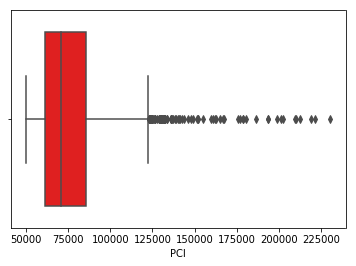

In [21]:
sns.boxplot(dem['PCI'], color='red')

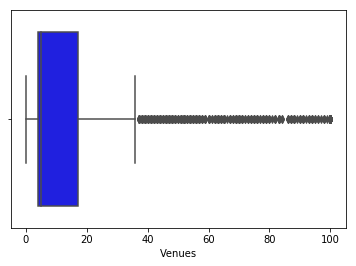

In [22]:
sns.boxplot(dem['Venues'], color='Blue')

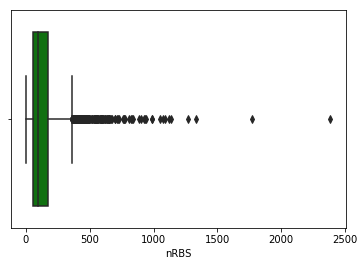

In [23]:
sns.boxplot(dem['nRBS'], color='Green')

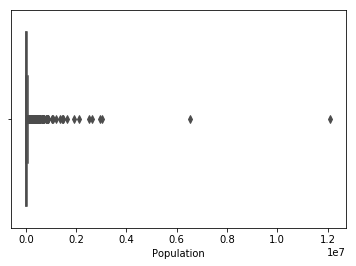

In [24]:
sns.boxplot(dem['Population'], color='Yellow')

In [25]:
dem.columns
dem_sub100=dem[(dem['Venues']<80)&(dem['RBS']<100)&(dem['Venues']>20)&(dem['Population']>1000)&(dem['Population']<300000)&(dem['PCI']<150000)]
dem_col=dem_sub100[['HDI','HDI Block', 'PCI', 'Population', 'RBS', 'Venues', 'nRBS', 'nVenues']]
dem['HDI Block'].value_counts()

35    584
36    522
34    493
37    403
33    332
38    238
32    156
39     93
31     58
40     32
30     23
29      8
41      5
42      5
43      1
25      1
27      1
Name: HDI Block, dtype: int64

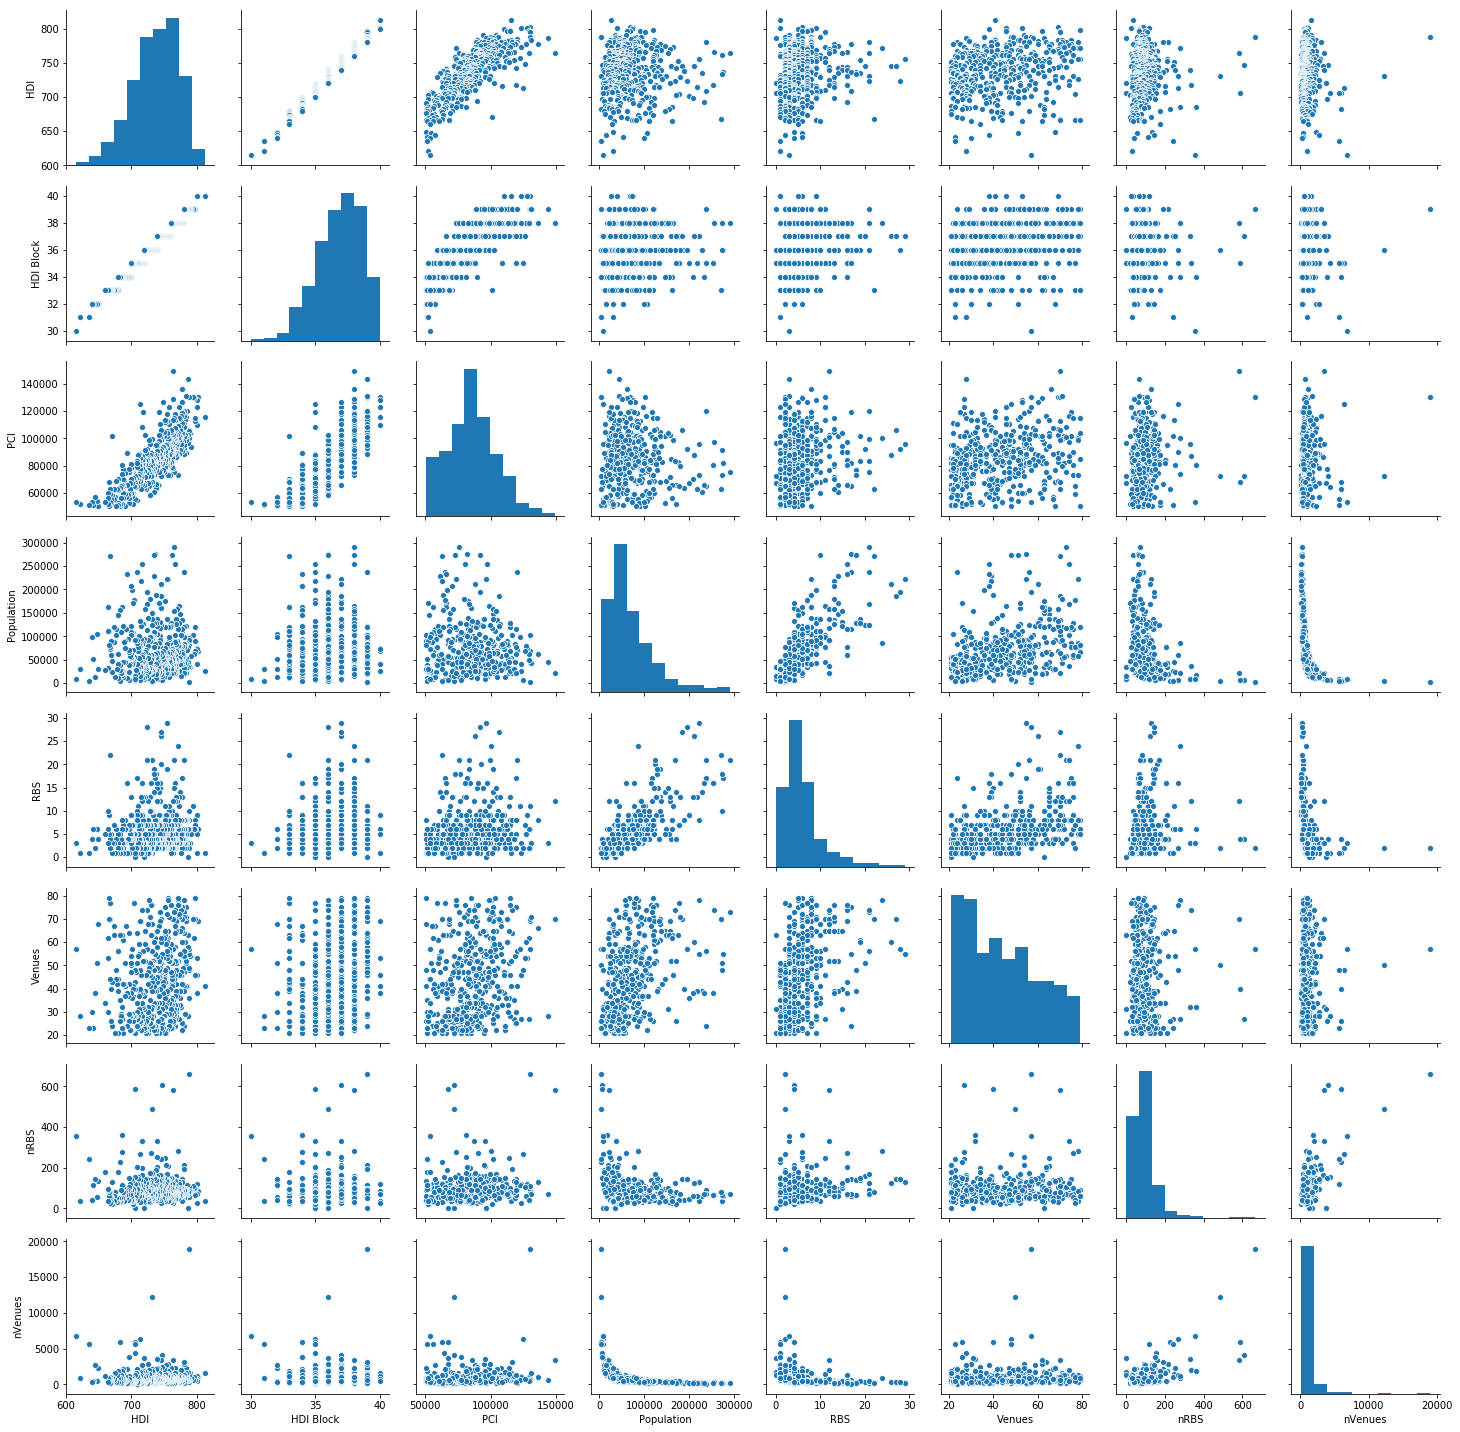

In [26]:
sns.pairplot(dem_col)

# CLASSIFICATION ANALYSIS

## Random Forest

In [27]:
dem.columns

Index(['City', 'HDI', 'State', 'HDI Block', 'PCI', 'Population', 'RBS',
       'Latitude', 'Longitude', 'Venues', 'nRBS', 'nVenues'],
      dtype='object')

In [28]:
X=dem[['PCI','Population','nRBS', 'nVenues']]
y=dem['HDI Block']

In [29]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=101)

In [30]:
rf=RandomForestClassifier()
rf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [31]:
y_pred=rf.predict(X_test)

In [32]:
print (classification_report(y_test, y_pred))
print('\n')
print (confusion_matrix(y_test, y_pred))

             precision    recall  f1-score   support

         29       0.00      0.00      0.00         2
         30       0.50      0.17      0.25         6
         31       0.00      0.00      0.00        23
         32       0.26      0.20      0.22        51
         33       0.23      0.29      0.26       103
         34       0.22      0.25      0.23       159
         35       0.25      0.27      0.26       183
         36       0.34      0.28      0.31       180
         37       0.33      0.36      0.34       131
         38       0.41      0.33      0.36        92
         39       0.42      0.37      0.39        35
         40       0.25      0.43      0.32         7
         41       0.00      0.00      0.00         3
         42       0.00      0.00      0.00         1

avg / total       0.29      0.28      0.28       976



[[ 0  0  0  1  0  1  0  0  0  0  0  0  0  0]
 [ 0  1  0  3  1  1  0  0  0  0  0  0  0  0]
 [ 0  0  0  6  7  7  3  0  0  0  0  0  0  0]
 [ 0  0  3 1

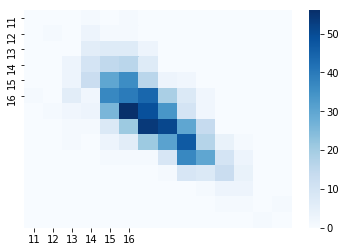

In [33]:
sns.heatmap(confusion_matrix(y_test, y_pred),xticklabels=[11,12,13,14,15,16], yticklabels=[11,12,13,14,15,16],cmap='Blues')

# Support Vector

In [34]:
X=dem[['PCI','Population','nRBS', 'nVenues']]
y=dem['HDI Block']

In [35]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=101)

In [36]:
svm=SVC()
svm.fit(X_train, y_train)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [37]:
y_pred=rf.predict(X_test)

In [38]:
print (classification_report(y_test, y_pred))
print('\n')
print (confusion_matrix(y_test, y_pred))

             precision    recall  f1-score   support

         29       0.00      0.00      0.00         2
         30       0.50      0.17      0.25         6
         31       0.00      0.00      0.00        23
         32       0.26      0.20      0.22        51
         33       0.23      0.29      0.26       103
         34       0.22      0.25      0.23       159
         35       0.25      0.27      0.26       183
         36       0.34      0.28      0.31       180
         37       0.33      0.36      0.34       131
         38       0.41      0.33      0.36        92
         39       0.42      0.37      0.39        35
         40       0.25      0.43      0.32         7
         41       0.00      0.00      0.00         3
         42       0.00      0.00      0.00         1

avg / total       0.29      0.28      0.28       976



[[ 0  0  0  1  0  1  0  0  0  0  0  0  0  0]
 [ 0  1  0  3  1  1  0  0  0  0  0  0  0  0]
 [ 0  0  0  6  7  7  3  0  0  0  0  0  0  0]
 [ 0  0  3 1

In [39]:
#dem.to_csv('C:/Users/Paulo/Desktop/Python/dem.csv')

# kNN

In [40]:
X=dem[['PCI','RBS','Venues', 'Population']]
dem['HDI Block']=dem['HDI'].apply(lambda x:x//50) #group HDI cities in 20 blocks, 50 points wide. This column will be the target for classificiation
y=dem['HDI Block']
X.head()

,PCI,RBS,Venues,Population
0,218941,14,100.0,159608
1,186622,1,36.0,3268
2,209656,85,100.0,485838
3,193390,23,100.0,135268
4,221507,59,100.0,363140


In [41]:
scaler = StandardScaler()
scaler.fit(X)
scaled_feat = scaler.transform(X)
scaled_X = pd.DataFrame(scaled_feat,columns=X.columns)
scaled_X.head()

,PCI,RBS,Venues,Population
0,6.803895,0.337419,3.084080,0.356322
1,5.267066,-0.140635,0.685269,-0.168574
2,6.362376,2.948326,3.084080,1.451606
3,5.588897,0.668379,3.084080,0.274603
4,6.925914,1.992219,3.084080,1.039660


In [42]:
knn=KNeighborsClassifier(n_neighbors=7)
X_train, X_test, y_train, y_test = train_test_split(scaled_X, y, test_size=0.33, random_state=101)
knn.fit(X_train, y_train)
y_pred=knn.predict(X_test)

In [43]:
print (classification_report(y_test, y_pred))
print('\n')
print (confusion_matrix(y_test, y_pred))

             precision    recall  f1-score   support

         11       0.00      0.00      0.00         2
         12       0.27      0.07      0.11        43
         13       0.62      0.63      0.62       299
         14       0.64      0.72      0.68       440
         15       0.65      0.55      0.60       181
         16       0.47      0.73      0.57        11

avg / total       0.62      0.63      0.62       976



[[  0   0   1   1   0   0]
 [  0   3  37   3   0   0]
 [  0   6 187 100   6   0]
 [  0   2  76 316  46   0]
 [  0   0   0  72 100   9]
 [  0   0   0   0   3   8]]


C:\Users\Paulo\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


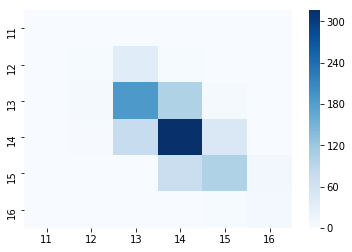

In [44]:
sns.heatmap(confusion_matrix(y_test, y_pred),xticklabels=[11,12,13,14,15,16], yticklabels=[11,12,13,14,15,16],cmap='Blues')



# Regression ANALYSIS

## Linear Regression

In [45]:
X=dem[['PCI','nRBS','nVenues']]
y=dem['HDI']
X.head()

,PCI,nRBS,nVenues
0,218941,87.714902,626.535011
1,186622,305.997552,11015.911873
2,209656,174.955438,205.829927
3,193390,170.032824,739.273147
4,221507,162.471774,275.375888


In [46]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=101)

In [47]:
lm=LinearRegression()
lm.fit(X_train, y_train)
y_pred=lm.predict(X_test)

In [48]:
print('Intercept',lm.intercept_)
print('Coefficients', lm.coef_)

Intercept 599.5050006942276
Coefficients [0.00145315 0.01310538 0.0022766 ]


In [52]:
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

Mean Absolute Error: 19.939649795002737
Root Mean Squared Error: 25.214952464433438


C:\Users\Paulo\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


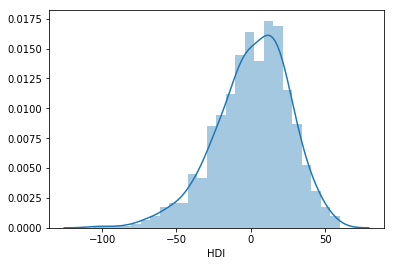

In [53]:
sns.distplot((y_test-y_pred))

# MAPS

In [51]:
dem['marker_color'] = pd.cut(dem['Venues'], bins=7, labels=['white','darkblue', 'blue', 'green', 'yellow', 'orange', 'red'])
# create map of Brazil using latitude and longitude values
map_downtown = folium.Map(location=[-23, -47], zoom_start=5)
#label = folium.Popup(label, parse_html=True)
for i in range (0,len(dem['City'])):
    folium.CircleMarker(
        [dem['Latitude'].iloc[i], dem['Longitude'].iloc[i]],
        radius=0.1,
        color=dem['marker_color'].iloc[i],
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_downtown) 
    
map_downtown